Do related immune lineages cluster together based on their ATAC-seq chromatin accessibility?


Exception in thread Thread-4 (_readerthread):
Traceback (most recent call last):
  File "c:\Users\janna\miniconda3\envs\data_analysis\Lib\threading.py", line 1041, in _bootstrap_inner
    self.run()
    ~~~~~~~~^^
  File "c:\Users\janna\miniconda3\envs\data_analysis\Lib\site-packages\ipykernel\ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
    ~~~~~~~~~~~~~~~~~~~~~^^^^^^
  File "c:\Users\janna\miniconda3\envs\data_analysis\Lib\threading.py", line 992, in run
    self._target(*self._args, **self._kwargs)
    ~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\janna\miniconda3\envs\data_analysis\Lib\subprocess.py", line 1612, in _readerthread
    buffer.append(fh.read())
                  ~~~~~~~^^
  File "<frozen codecs>", line 325, in decode
UnicodeDecodeError: 'utf-8' codec can't decode byte 0x81 in position 109: invalid start byte
c:\Users\janna\miniconda3\envs\data_analysis\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known

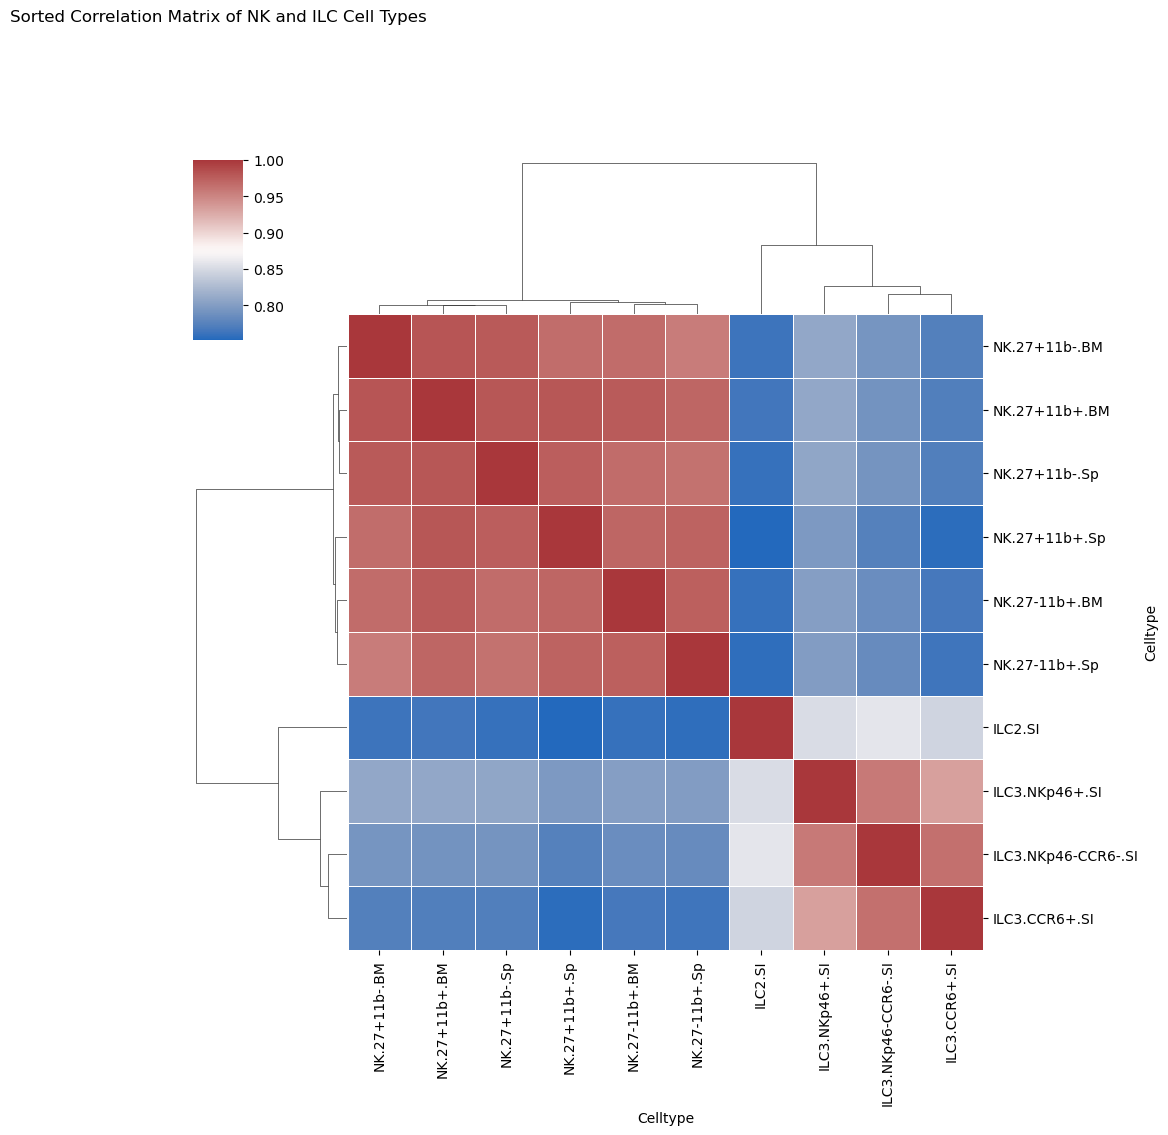

Ø Korrelation innerhalb NK-Zellen: 0.90
Ø Korrelation innerhalb ILC-Zellen: 0.90
Ø Korrelation zwischen NK und ILC: 0.82


c:\Users\janna\miniconda3\envs\data_analysis\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


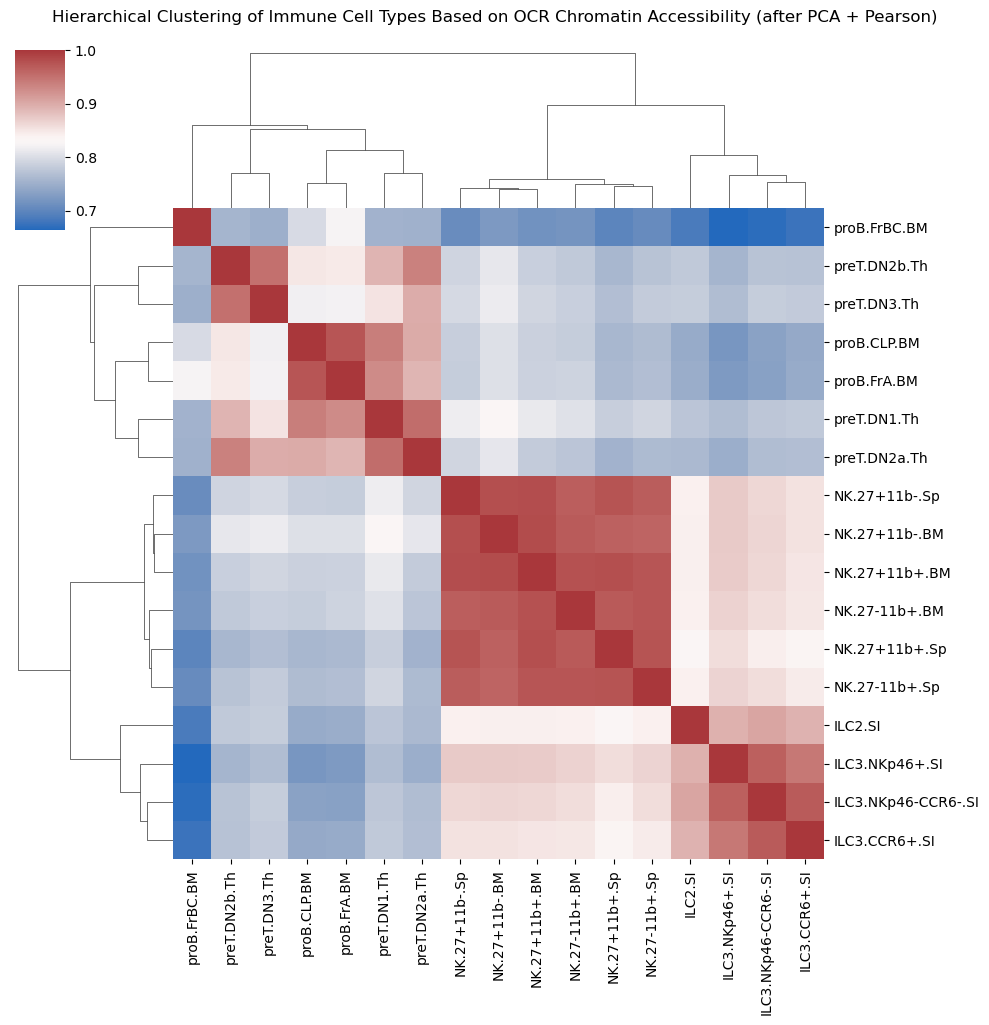

In [1]:

print("Do related immune lineages cluster together based on their ATAC-seq chromatin accessibility?")
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import pdist
import seaborn as sns
import matplotlib.pyplot as plt


#Load the data
df_raw = pd.read_csv("data/ImmGenATAC18_AllOCRsInfo.csv", header=0, quotechar='"', low_memory=False)

# Extract only ILC and NK columns

df_expr_NK_ILC = df_raw[['NK.27+11b-.BM', 'NK.27+11b+.BM', 'NK.27-11b+.BM', 'NK.27+11b-.Sp',
       'NK.27+11b+.Sp', 'NK.27-11b+.Sp', 'ILC2.SI', 'ILC3.NKp46-CCR6-.SI',
       'ILC3.NKp46+.SI', 'ILC3.CCR6+.SI']] 
#Transpose
df_expr_NK_ILC= df_expr_NK_ILC.T
df_expr_NK_ILC.index.name = "Celltype"

from sklearn.cluster import KMeans

#kmeans clustering
k = 9
kmeans = KMeans(n_clusters=k, random_state=42)
df_expr_NK_ILC['Cluster'] = kmeans.fit_predict(df_expr_NK_ILC)

# Pearson correlation across immune cell types
corr_matrix2 = np.corrcoef(df_expr_NK_ILC)

# Hierarchical clustering using Ward's linkage
linkage_matrix2 = linkage(pdist(df_expr_NK_ILC, metric='euclidean'), method='ward')


import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation matrix from chromatin accessibility data (rows = cell types, cols = peaks)
corr_matrix = df_expr_NK_ILC.drop('Cluster', axis=1).T.corr()

# Use clustermap for automatic hierarchical sorting
sns.clustermap(corr_matrix, cmap='vlag', linewidths=0.5, figsize=(10, 10))
plt.title("Sorted Correlation Matrix of NK and ILC Cell Types", pad=100)
plt.show()

from scipy.cluster.hierarchy import linkage, leaves_list

# sorting cell types with hierarchichal clustering
linkage_matrix = linkage(corr_matrix, method='ward')
ordered_idx = leaves_list(linkage_matrix)
sorted_celltypes = corr_matrix.index[ordered_idx]
sorted_corr_matrix = corr_matrix.loc[sorted_celltypes, sorted_celltypes]

# extract NK and ILC cells
nk_cells = [celltype for celltype in sorted_celltypes if "NK" in celltype]
ilc_cells = [celltype for celltype in sorted_celltypes if "ILC" in celltype]

# =Mean correlation between NK cells
nk_corr = sorted_corr_matrix.loc[nk_cells, nk_cells]
mean_corr_nk = nk_corr.values[np.triu_indices(len(nk_cells), k=1)].mean()

#man correlation between ILC cells
ilc_corr = sorted_corr_matrix.loc[ilc_cells, ilc_cells]
mean_corr_ilc = ilc_corr.values[np.triu_indices(len(ilc_cells), k=1)].mean()

# mean correlation between ILC and NK cells
between_corr = sorted_corr_matrix.loc[nk_cells, ilc_cells]
mean_corr_between = between_corr.values.mean()

#print results
print(f"Ø Korrelation innerhalb NK-Zellen: {mean_corr_nk:.2f}")
print(f"Ø Korrelation innerhalb ILC-Zellen: {mean_corr_ilc:.2f}")
print(f"Ø Korrelation zwischen NK und ILC: {mean_corr_between:.2f}")


# Extract only the relevant cell type columns; including pro T-Cells and pre-Tcells
df_expr = df_raw[['NK.27+11b-.BM', 'NK.27+11b+.BM', 'NK.27-11b+.BM', 'NK.27+11b-.Sp',
       'NK.27+11b+.Sp', 'NK.27-11b+.Sp', 'ILC2.SI', 'ILC3.NKp46-CCR6-.SI',
       'ILC3.NKp46+.SI', 'ILC3.CCR6+.SI', 'proB.CLP.BM','proB.FrA.BM','proB.FrBC.BM', 'preT.DN1.Th','preT.DN2a.Th', 'preT.DN2b.Th','preT.DN3.Th']]
df_expr = df_expr.iloc[:5000, :]
df_expr.index = df_raw.iloc[:5000, :] 

# Transpose to have cell types as rows and OCRs as columns
df_expr = df_expr.T
df_expr.index.name = "Celltype"

#kmeans clustering

k = 7
kmeans = KMeans(n_clusters=k, random_state=42)
df_expr['Cluster'] = kmeans.fit_predict(df_expr)


# Pearson correlation across immune cell types
corr_matrix = np.corrcoef(df_expr)

# Hierarchical clustering using Ward's linkage
linkage_matrix = linkage(pdist(df_expr, metric='euclidean'), method='ward')

# Plot heatmap with clustering
sns.clustermap(corr_matrix, row_linkage=linkage_matrix, col_linkage=linkage_matrix,
               cmap="vlag", figsize=(10, 10), xticklabels=df_expr.index, yticklabels=df_expr.index)
plt.suptitle("Hierarchical Clustering of Immune Cell Types Based on OCR Chromatin Accessibility (after PCA + Pearson)", y=1.02)
plt.show()



In this section, we want to investigate if related cell types cluster together based on their ATAC signal and load the ATAC data set. We want to look closer to the family of ILC and NK cells and therefore extract the desired columns from the ATAC-seq data. We transpose the matrix in order to cluster the cell types (in the rows after transposing) according to their ATAC Signals (Columns).
To determine, how strongly the immune cell lineages correlate with the ATAC signals, we peformed a KMeans clustering and calculated the pearson correlation. For visualization, we computed a heatmeap and a dendogram. We clearly see a distinct clustering between ILC and Nk subtypes: the ILC subtypes cluster together, aswell as the NK subtypes. This shows, that clustering produced a known relationship between cell types. The ILC2 cells show a low correlation with the ILC3 cell types. This mirrors the known relationship between ILC2 and ILC3 cells: They have different functions in the immune systeme and secrete different cytokines (IL17; IL22 vs Il13; IL9). Next, we calculated the mean correlation between NK cells , ILC cells and between NK and ILC cells. There is a high correlation within each cell type (0.90)
Both NK cells and ILCs show very similar chromatin accessibility profiles within their respective groups. There is a slightly lower correlation between NK and ILC cells (0.82)
A correlation of 0.82 is still relatively high, indicating shared regulatory features. This reflects the developmental and functional relatedness of NK and ILC cells: Both originate from common lymphoid progenitors and are involved in the innate immune response. However, the lower correlation compared to within-group values shows that there are distinct epigenetic differences.

Next, we compare the ILC and NK subtypes to the closely related pro T-Cells and preT-cells.Again, peform KMeans clustering and calculate the pearson correlation. We used n=7 clusters, the ideal number was determined with the elbow method. To visualize the correlation and clustering, we plot a heatmap and a dendogram. For linkage, we use Ward's linkage, since it minimalizes the variability between clusters and is less susceptible to noise and outliers.
In the heatmap, the NK cells form a dinstinct cluster with a high correlation (>0.9). They clearly seperate from other immune lineages, mirroring the known relationships between the immune cell types. Different NK subtypes are in the same cluster, supporting the hypothesis that the ATAC signal is specific for certain lineages. ILC subtypes also cluster together in both heatmaps (correlation >0.9) but don't show a particularly strong correlation with NK cells. Still, they correlate stronger with NK cells than with the other immune cell types, mirroring the known close relationship between bith lineages and further supporting the hypothesis, that ATAC signal correlates with immune cell differentiation. Both ILC and NK cells do not cluster with pro T-cells and pre B-cells, indicating, that clustering based on chromatin availability reproduces a known relationship between cells.